In [1]:
import numpy as np
import pandas as pd

import random
import sys, os
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
############################ 
#Recording coefficient of variation for abundances
def recordCV(data_df, coeff_df, random_run_count = 0):
    
    #We will record the CV scores 
    
    #############################
    #Select peptides occuring on each protein
    all_proteins = np.unique(data_df['Protein'].values)
    print("Number of proteins: ", len(all_proteins))
    
    run_start_index = 11
    
    all_raw_CVs = []
    all_adj_CVs = []
    protein_sizes = []
    
    #For each protein, calculate CV before and after adjustment
    for protein in all_proteins:
        
        sub_df = data_df[data_df['Protein'] == protein]
        sub_peptide_indices =  [np.where(data_df.index == i)[0][0] for i in sub_df.index]

        protein_sizes.append(len(sub_peptide_indices))
        
        all_run_raw_CVs = []
        all_run_adj_CVs = []
        
        #Calculate for each run
        for random_experiment in range(run_start_index, data_df.shape[1]):
            
            #For each peptide, record the quantities
            quantities = data_df.iloc[sub_peptide_indices, random_experiment]
            #print(quantities)
            
            #Reject sample if any values are nan
            if np.all(~np.isnan(quantities.values.ravel())) and \
                   np.all(quantities.values.ravel() != 0.0):

                #Calculate the abundances by dividing quantities to peptide coefficients
                sibling_coefficients = coeff_df.iloc[sub_peptide_indices, 0]
#                 print("Sibling intensities: ", quantities)
#                 print("Sibling coeffs: ", sibling_coefficients)

                sibling_abundances = quantities.values.ravel() / sibling_coefficients.values.ravel()
#                 print("Sibling abundances: ", sibling_abundances)

                #Record final CVs
                raw_CV = np.std(quantities.values.ravel()) / np.mean(quantities.values.ravel())
                adj_CV = np.std(sibling_abundances) / np.mean(sibling_abundances)
                
                all_run_raw_CVs.append(raw_CV)
                all_run_adj_CVs.append(adj_CV)
        
#                 print("Raw run CVs ", np.mean(all_run_raw_CVs))
#                 print("Adj run CVs ", np.mean(all_run_adj_CVs))
    
        all_raw_CVs.append(all_run_raw_CVs)
        all_adj_CVs.append(all_run_adj_CVs)

    all_raw_CVs = np.array(all_raw_CVs)
    all_adj_CVs = np.array(all_adj_CVs)

#     print("Raw CVs ", np.mean(all_raw_CVs))
#     print("Adj CVs ", np.mean(all_adj_CVs))
    
    return [all_raw_CVs, all_adj_CVs, protein_sizes]


In [3]:
n_runs = 120
seq_length = 60

#Read dataset
data_df = pd.read_csv('preprocess_datasets/preprocessed_datasets/2019_guo_nci60_formatted_peptide_quants.tsv', 
                      sep = '\t', index_col = 0)

print("Peptide df ", data_df.shape)
print("Peptide df ", data_df.head())

#Input 1 is peptide intensity measurements
#Also record intensity measurements for pairs
q_df = data_df.iloc[:, -n_runs:]

#Normalize the intensities such that the sum of elements in each column is equal
X = q_df.values
X = (X / X.sum(axis=0, keepdims=1)) * X.shape[0]
q_df = pd.DataFrame(X, index = q_df.index, columns = q_df.columns)
data_df.iloc[:, -n_runs:] = q_df

#Input 2 is protein mappings
#Convert protein labels to int values
protein_labels = data_df['Protein'].values
unique_proteins = np.unique(protein_labels)
n_proteins = len(unique_proteins)
print("Number of unique proteins ", n_proteins)
int_protein_labels = [np.where(protein_labels[i] == unique_proteins)[0][0] for i in range(protein_labels.shape[0])]
int_protein_labels = np.asarray(int_protein_labels)
print("Protein labels ", int_protein_labels)
n_peptides = data_df.shape[0]

print("No of peptides: ", n_peptides)
print("No of proteins: ", n_proteins)
print("No of runs: ", n_runs)

#Split the proteins into train/validation/test sets

train_proteins, test_proteins = train_test_split((np.arange(len(np.unique(protein_labels)))), 
                                   test_size=0.2, random_state=12345)

#Define train/validation/test peptide pairs
train_peptides = np.concatenate([list(np.where(protein_labels == np.unique(protein_labels)[p])[0]) for p in train_proteins])
test_peptides = np.concatenate([list(np.where(protein_labels == np.unique(protein_labels)[p])[0]) for p in test_proteins])

print("No of train/test proteins: %d/%d" % (len(train_proteins), len(test_proteins)))
print("No of train/test peptides: %d/%d" % (len(train_peptides), len(test_peptides)))

#Split the runs into train/validation/test sets
#Modified code for replicate samples
train_runs, test_runs = train_test_split((np.arange(q_df.shape[1] / 2)), 
                                   test_size=0.2, random_state=12345)

train_runs = np.array([[2*i, 2*i+1] for i in train_runs]).astype(int).ravel()
test_runs = np.array([[2*i, 2*i+1] for i in test_runs]).astype(int).ravel()

print("No of train runs ", len(train_runs))
print("No of test runs ", len(test_runs))

Peptide df  (14472, 132)
Peptide df                        Peptide Protein gene symbol        R2   best mscore  \
1    VHCCFYFISPFGHGLKPLDVAFMK  Q15019       2-Sep  0.935026  1.920000e-07   
3                   VNIVPVIAK  Q15019       2-Sep  0.917310  4.010000e-09   
4  QQPTQFINPETPGYVGFANLPNQVHR  Q15019       2-Sep  0.897582  2.160000e-08   
5            STLINSLFLTDLYPER  Q15019       2-Sep  0.893410  1.060000e-08   
6           ASIPFSVVGSNQLIEAK  Q15019       2-Sep  0.882319  9.200000e-09   

   numNA  Charge 1  Charge 2  Charge 3  Charge 4  ...  RE_CAKI1_a  RE_CAKI1_b  \
1      4         0         0         0         0  ...    184888.7    157024.0   
3      0         0         1         0         0  ...    623419.3    676515.0   
4      0         0         0         1         0  ...    121129.1    111926.1   
5      0         0         1         0         0  ...    332466.8    303315.1   
6      0         0         1         0         0  ...    313338.2    307400.9   

   RE_RXF393_

In [4]:
#Split the data into training and test set
data_df_train = data_df.iloc[train_peptides]
data_df_test = data_df.iloc[test_peptides]

data_df_train = pd.concat([data_df_train.iloc[:, :-n_runs], data_df_train.iloc[:, data_df.shape[1] - n_runs + train_runs]], axis = 1)
data_df_test = pd.concat([data_df_test.iloc[:, :-n_runs], data_df_test.iloc[:, data_df.shape[1] - n_runs + test_runs]], axis = 1)

data_df_test

,Peptide,Protein,gene symbol,R2,best mscore,numNA,Charge 1,Charge 2,Charge 3,Charge 4,...,OV_NCIADRRES_a,OV_NCIADRRES_b,CNS_SF268_a,CNS_SF268_b,ME_M14_a,ME_M14_b,LE_RPMI8226_a,LE_RPMI8226_b,LC_HOP62_a,LC_HOP62_b
4809,SGAYLIPLLER,P26196,DDX6,0.928086,9.730000e-08,0,0,1,0,0,...,1.478082,1.575990,2.164240,1.983903,1.667913,1.629159,2.070746,2.246474,1.170623,1.166468
4810,GPVKPTGGPGGGGTQTQQQMNQLK,P26196,DDX6,0.851250,1.240000e-07,0,0,0,1,0,...,0.145045,0.130964,0.167784,0.193088,0.124999,0.129642,0.155914,0.182387,0.142880,0.146613
4811,NLVCTDLFTR,P26196,DDX6,0.823734,1.340000e-07,0,0,1,0,0,...,0.780499,0.775304,0.915532,1.011107,0.784299,0.746273,0.963873,1.223151,0.603805,0.693223
4812,QILLYSATFPLSVQK,P26196,DDX6,0.823174,3.340000e-08,2,0,1,0,0,...,0.433950,0.459651,0.606071,0.643881,0.366742,0.363102,0.605414,0.627811,0.358444,0.368527
4813,GVTQYYAYVTER,P26196,DDX6,0.706512,7.890000e-08,0,0,1,0,0,...,0.636593,0.573236,0.828799,0.888261,0.578414,0.539819,0.740201,0.895105,0.537100,0.553320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15502,VSANKGEIGDATPFNDAVNVQK,P30876,POLR2B,0.341847,5.570000e-06,0,0,0,1,0,...,0.323568,0.317434,0.363127,0.403714,0.394211,0.370697,0.436474,0.410652,0.385603,0.356419
15503,TVTLPENEDELESTNRR,P30876,POLR2B,0.241753,1.170000e-05,2,0,0,1,0,...,0.223208,0.246524,0.244088,0.265507,0.327164,0.176937,0.254458,0.244531,0.222720,0.232824
18799,LIIAGTSCYSR,P34896,SHMT1,0.748749,7.390000e-08,2,0,1,0,0,...,0.452099,0.529072,0.499566,0.573578,0.812163,0.785860,0.611427,0.574226,0.594737,0.551265
18800,VLEACSIACNK,P34896,SHMT1,0.646249,2.220000e-08,4,0,1,0,0,...,0.444115,0.626354,0.469968,0.580414,0.799830,0.767582,0.617601,0.602389,0.479486,0.693414


In [5]:
#Define function to create scatter plots
#Note that this scatter plot is for peptide ratios
def createPlots(scores, n_bins = 100):
    
    #Create comparison scatter plots
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 20)

    SMALL_SIZE = 40
    MEDIUM_SIZE = 50
    BIGGER_SIZE = 70

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    print("Creating a plot for all proteins...")
    raw_scores = scores[0].mean(axis = 1)
    adj_scores = scores[1].mean(axis = 1) 
    protein_sizes = scores[2]
    
    count_raw = 0
    count_adj = 0
    for i in range(raw_scores.shape[0]):
        if raw_scores[i] > adj_scores[i]:
            plt.scatter(raw_scores[i], 
                        adj_scores[i], 
                        s = 500, alpha = 0.5, color = "#8854d0")
            count_raw += 1

        elif raw_scores[i] < adj_scores[i]:
            plt.scatter(raw_scores[i], 
                        adj_scores[i], 
                        s = 500, alpha = 0.5, color = '#eb4d4b')
            count_adj += 1
            
    print("Count raw ", count_raw)
    print("Count adj ", count_adj)

    plt.plot([0.0, 2.0], [0.0, 2.0], '--', lw = 5, color = 'Black', zorder = -1)
    plt.xlim([0.0, 2.0])
    plt.ylim([0.0, 2.0])
    
    plt.xticks([0.0, 0.5, 1.0, 1.5, 2.0])
    plt.yticks([0.0, 0.5, 1.0, 1.5, 2.0])
    
    plt.xlabel('Coefficient of variation for observed abundances')
    plt.ylabel('Coefficient of variation for adjusted abundances')
    plt.grid()
    plt.show()
   
    print("Creating a plot for proteins with 5+ peptides...")
    
    #Create comparison scatter plots
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 20)

    SMALL_SIZE = 40
    MEDIUM_SIZE = 50
    BIGGER_SIZE = 70

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    raw_scores = scores[0].mean(axis = 1)
    adj_scores = scores[1].mean(axis = 1) 
    protein_sizes = scores[2]
    
    count_raw = 0
    count_adj = 0
    for i in range(raw_scores.shape[0]):
        if protein_sizes[i] > 5:
            if raw_scores[i] > adj_scores[i]:
                plt.scatter(raw_scores[i], 
                            adj_scores[i], 
                            s = 500, alpha = 0.5, color = "#8854d0")
                count_raw += 1

            elif raw_scores[i] < adj_scores[i]:
                plt.scatter(raw_scores[i], 
                            adj_scores[i], 
                            s = 500, alpha = 0.5, color = '#eb4d4b')
                count_adj += 1
            
    print("Count raw ", count_raw)
    print("Count adj ", count_adj)

    plt.plot([0.0, 2.0], [0.0, 2.0], '--', lw = 5, color = 'Black', zorder = -1)
    plt.xlim([0.0, 2.0])
    plt.ylim([0.0, 2.0])
    
    plt.xticks([0.0, 0.5, 1.0, 1.5, 2.0])
    plt.yticks([0.0, 0.5, 1.0, 1.5, 2.0])
    
    plt.xlabel('Coefficient of variation for observed abundances')
    plt.ylabel('Coefficient of variation for adjusted abundances')
    plt.grid()
    plt.show()

In [6]:
#Read training coefficients
coeff_df = pd.read_csv('trained_models/2019_guo_nci60/2019_guo_nci60_inferred_coefficients.tsv', sep = '\t', index_col = 0)
print("Coefficients ", coeff_df.shape)
coeff_df = coeff_df.abs()
coeff_df.sort_values(by = '0')

Coefficients  (14472, 1)


,0
85,0.455091
21561,0.455394
7615,0.455402
3625,0.455432
20917,0.455433
...,...
9473,6.578577
18463,8.726971
6535,9.903713
5762,10.632017


Number of proteins:  425
Creating a plot for all proteins...
Count raw  303
Count adj  122


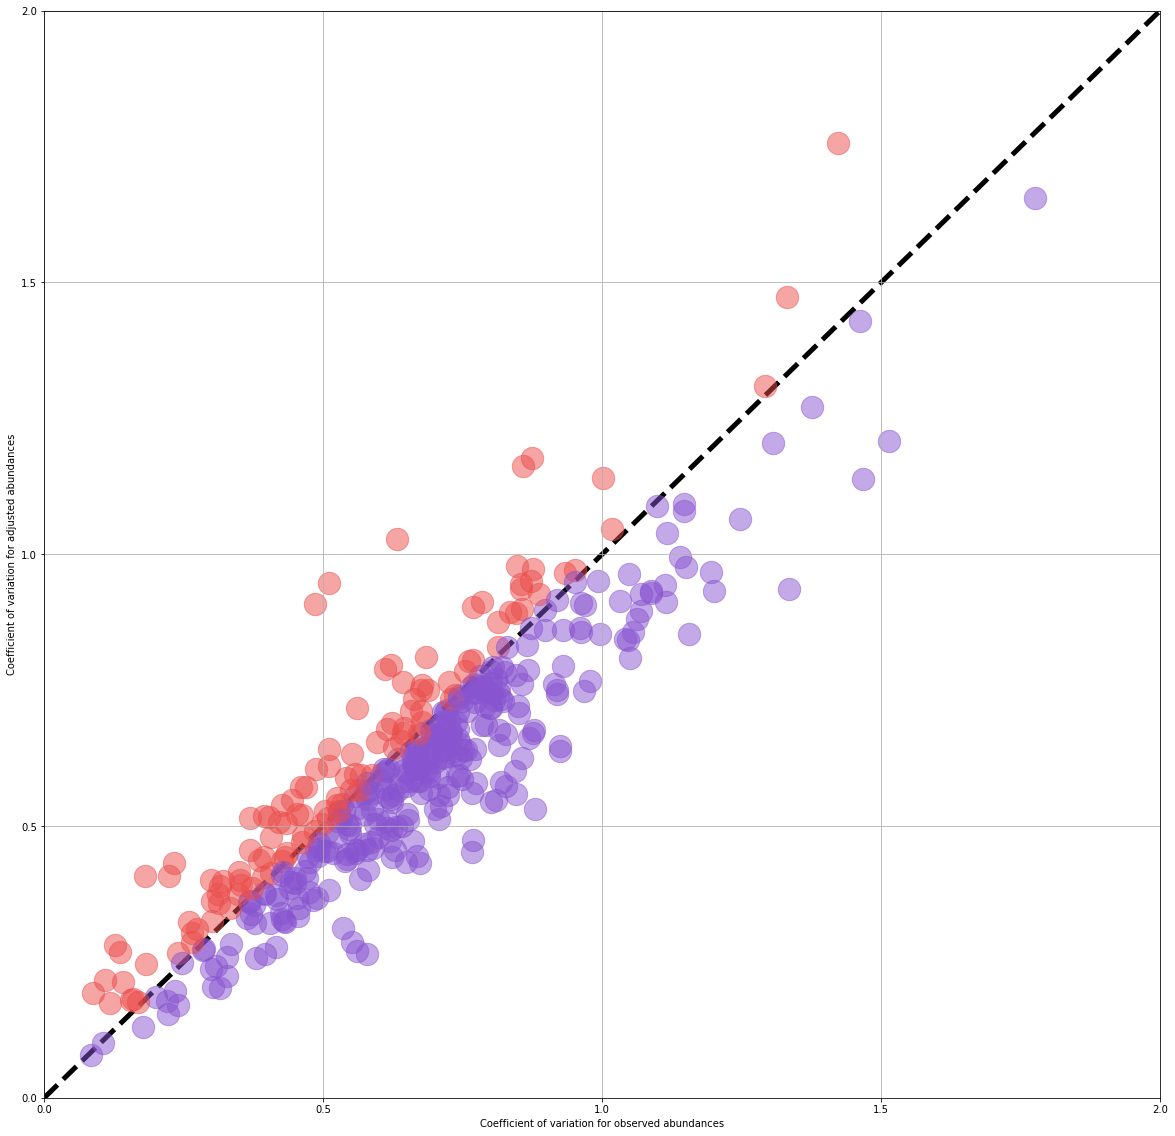

Creating a plot for proteins with 5+ peptides...
Count raw  125
Count adj  30


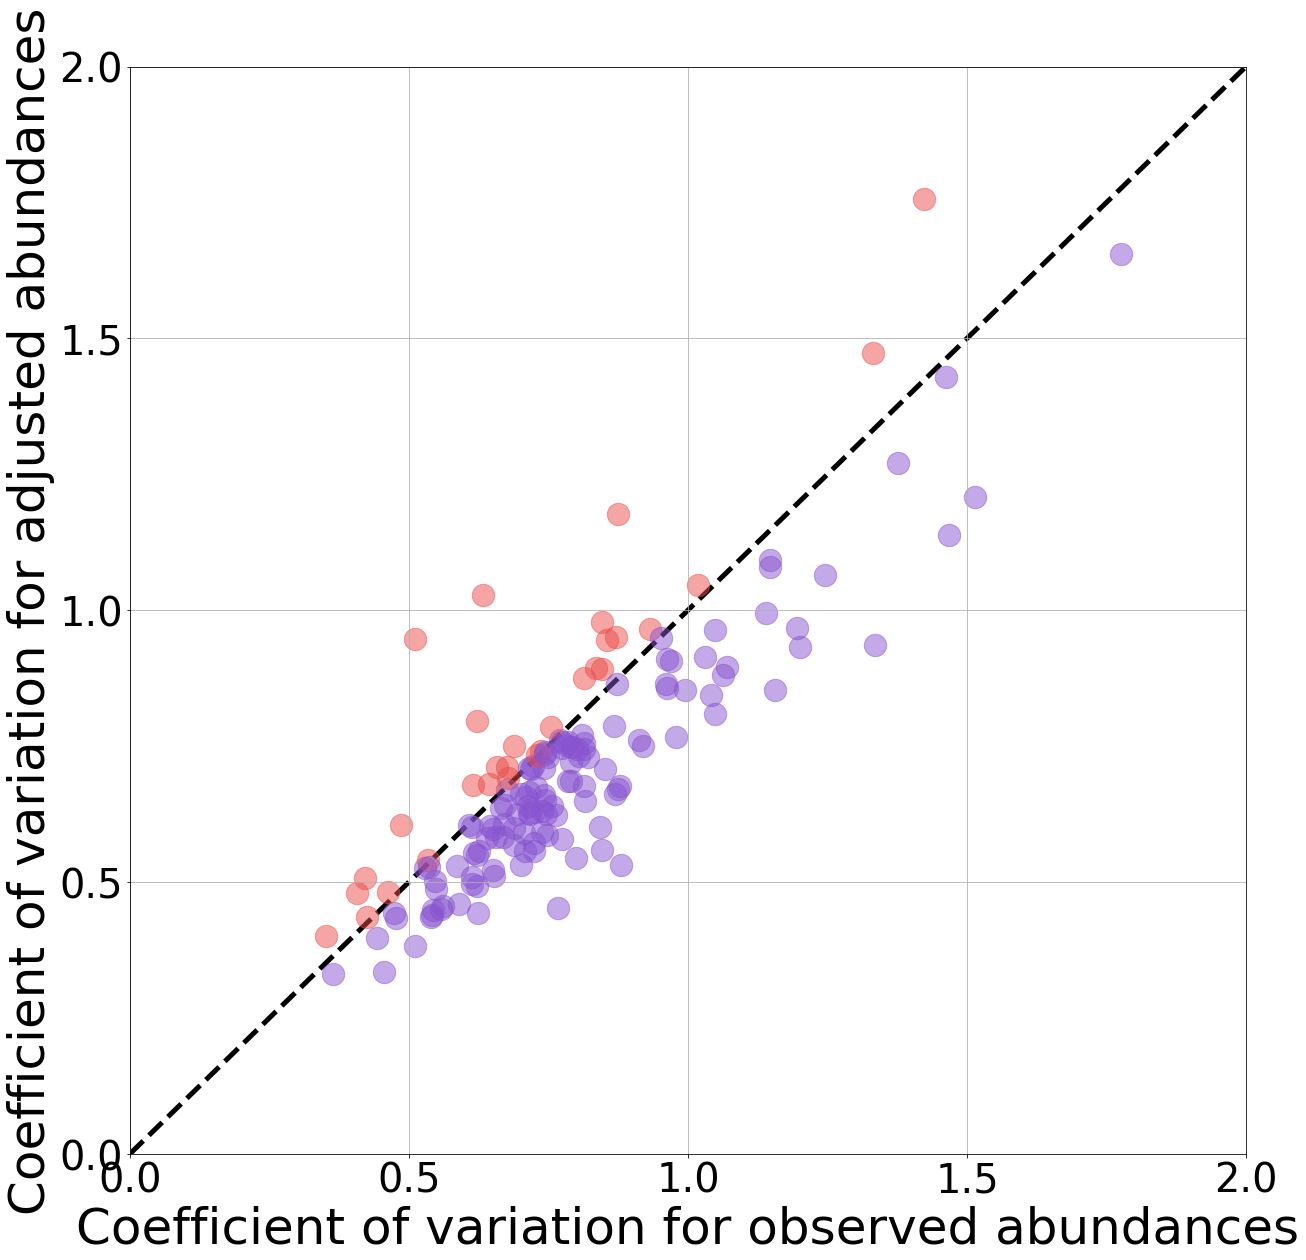

In [7]:
#Create test plots
results_test = recordCV(data_df_test, coeff_df.loc[data_df_test.index])
createPlots(results_test)